In [1]:
from FinancialMachineLearning.features.microstructure import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import os
os.chdir('..')
os.chdir('..')
os.getcwd()

'/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning'

In [3]:
data = pd.read_parquet('./Data/clean_IVE_fut_prices.parq')

#### Tick rule

In [4]:
aggressor = TickRule(data['price'])
aggressor

dates
2009-09-28 09:30:00    1.0
2009-09-28 09:30:00   -1.0
2009-09-28 09:31:32    1.0
2009-09-28 09:31:33    1.0
2009-09-28 09:31:50    1.0
                      ... 
2018-10-05 15:59:59    1.0
2018-10-05 15:59:59    1.0
2018-10-05 16:00:00    1.0
2018-10-05 16:10:00    1.0
2018-10-05 18:30:00    1.0
Length: 1416200, dtype: float64

#### The Roll Model

In [5]:
spread, noise = RollModel(data['price'])
spread, noise

(0.29004042406268316, -0.16645774734381774)

#### Range Volatility

In [6]:
from FinancialMachineLearning.barsampling.standard_bar import dollarBar

date_time = pd.Series(data.index)
data.index = range(len(data))
new_data = pd.concat([date_time, data['price'], data['v']], axis=1)
new_data.columns = ['date', 'price', 'volume']
print(new_data.head(20))
print('Rows:', new_data.shape[0])
new_data.to_csv('./Data/maks_tick_data.csv', index=False)

                  date    price  volume
0  2009-09-28 09:30:00  50.7900     100
1  2009-09-28 09:30:00  50.7100     638
2  2009-09-28 09:31:32  50.7500     100
3  2009-09-28 09:31:33  50.7500     100
4  2009-09-28 09:31:50  50.7500     300
5  2009-09-28 09:31:51  50.7500     300
6  2009-09-28 09:32:06  50.7800     300
7  2009-09-28 09:32:06  50.7800     500
8  2009-09-28 09:32:06  50.7800     100
9  2009-09-28 09:32:56  50.8226     100
10 2009-09-28 09:33:02  50.8100     500
11 2009-09-28 09:33:02  50.8100     300
12 2009-09-28 09:33:08  50.8200     500
13 2009-09-28 09:33:08  50.8200     298
14 2009-09-28 09:33:35  50.8100     100
15 2009-09-28 09:33:54  50.8200     100
16 2009-09-28 09:33:54  50.8200     400
17 2009-09-28 09:34:58  50.8000     100
18 2009-09-28 09:34:58  50.8000     200
19 2009-09-28 09:36:32  50.8500     300
Rows: 1416200


In [7]:
threshold = 1000000
dv = dollarBar('./Data/maks_tick_data.csv', threshold = threshold, batch_size = 1000000, verbose = True)
dv

Reading data in batches:
Batch number: 0
Batch number: 1
Returning bars 


,date_time,open,high,low,close,volume
0,2009-09-28 09:46:35,50.7900,51.0700,50.710,51.07,19844
1,2009-09-28 09:53:49,51.0700,51.1500,51.050,51.14,20324
2,2009-09-28 09:55:26,51.1400,51.1500,51.129,51.14,19622
3,2009-09-28 10:02:52,51.1400,51.2600,51.080,51.25,22319
4,2009-09-28 10:10:21,51.2500,51.2900,51.190,51.29,21519
...,...,...,...,...,...,...
50761,2018-10-05 15:58:23,116.2425,116.2425,116.160,116.19,9647
50762,2018-10-05 15:59:20,116.2000,116.2125,116.150,116.18,8821
50763,2018-10-05 15:59:55,116.1800,116.2100,116.140,116.19,9196
50764,2018-10-05 15:59:59,116.2000,116.2000,116.190,116.20,9700


In [8]:
vol = RangeVolatility(dv.high, dv.low, window = 50)

Text(0.5, 1.0, 'Estimated Range Volatility')

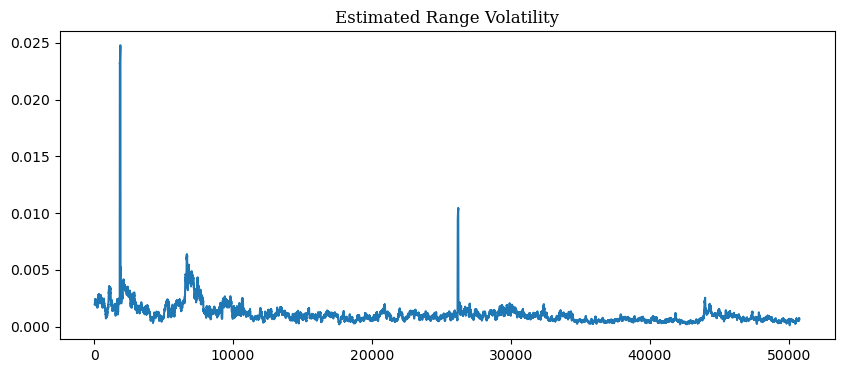

In [9]:
plt.figure(figsize = (10,4))
vol.plot()
plt.title('Estimated Range Volatility', fontsize = 12, fontfamily = 'Serif')

Text(0.5, 1.0, 'Dollar Value Bars')

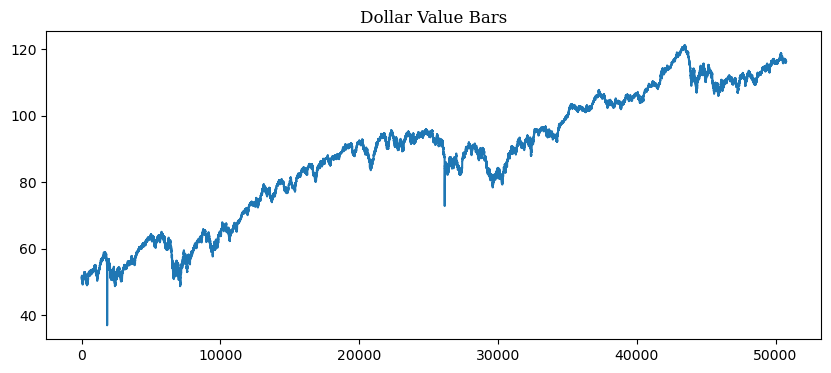

In [10]:
plt.figure(figsize = (10,4))
dv.close.plot()
plt.title('Dollar Value Bars', fontsize = 12, fontfamily = 'Serif')

#### Corwin Schultz Spread

In [11]:
spread = CorwinSchultzSpread(dv.high, dv.low, 100)
vol = BeckerParkinsonVolatility(dv.high, dv.low, 100)

Text(0.5, 1.0, 'Corwin Schultz Spread')

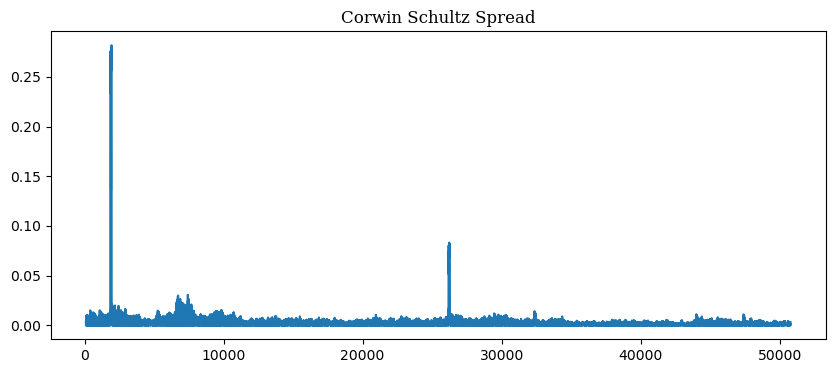

In [12]:
plt.figure(figsize = (10,4))
plt.plot(spread)
plt.title('Corwin Schultz Spread', fontsize = 12, fontfamily = 'Serif')

Text(0.5, 1.0, 'Estimated Backer Parkinson Volatility')

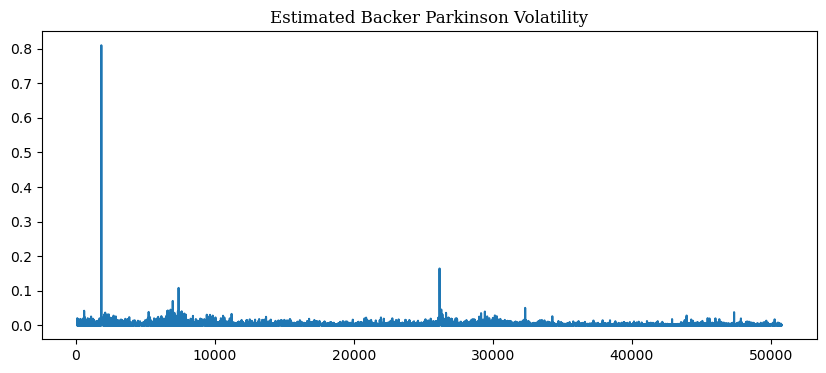

In [13]:
plt.figure(figsize = (10,4))
plt.plot(vol)
plt.title('Estimated Backer Parkinson Volatility', fontsize = 12, fontfamily = 'Serif')

#### Kyle's Lambda

In [14]:
aggressor = TickRule(dv['close'])
aggressor

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
50761   -1.0
50762   -1.0
50763    1.0
50764    1.0
50765    1.0
Length: 50766, dtype: float64

In [15]:
from FinancialMachineLearning.barsampling.bar_feature import BarFeature
kyles_lambda_feature = BarFeature(name = 'kyles_lambda', function= lambda df: kyleLambda(df['price'], df['volume'], aggressor))

In [22]:
kyles_lambda_feature

In [17]:
bars = dollarBar('./Data/maks_tick_data.csv', 
                 threshold = 1000000, batch_size = 1000000, 
                 additional_features = [kyles_lambda_feature])
plt.figure(figsize = (10, 4))
bars['kyles_lambda'].hist()

Reading data in batches:
Batch number: 0


ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

#### Amihud's Lambda

In [23]:
dollar_volume_feature = BarFeature(name = 'dollar_volume', function= lambda df: dollarVolume(dv['close'], dv['volume']))

In [ ]:
bars = dollarBar('./Data/maks_tick_data.csv', threshold = 1000000, batch_size = 1000000,
                       additional_features=[dollar_volume_feature])
lambda_ = amihudLambda(bars['close'], bars['dollar_volume'])
lambda_

#### Hasbrouck's Lambda

In [26]:
def hasbroucks_flow(tick_prices, tick_volumes, tick_sings):
    return (np.sqrt(tick_prices * tick_volumes) * tick_sings).sum()
def get_hasbroucks_flow(df):
    tick_signs = TickRule(df['price'])
    return hasbroucks_flow(df['price'], df['volume'], tick_signs)

In [29]:
hasbroucks_flow_feature = BarFeature(name = 'hasbroucks_flow', function=get_hasbroucks_flow)
bars = dollarBar('./Data/maks_tick_data.csv', threshold = 1000000, batch_size = 1000000,
                 additional_features=[hasbroucks_flow_feature])

lambda_ = hasbrouckLambda(bars['close'], bars['hasbroucks_flow'], aggressor)
lambda_

Reading data in batches:
Batch number: 0
Batch number: 1
Returning bars 


/Users/junghunlee/anaconda3/envs/FinancialMachineLearning/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


3977996.496553985

#### Third Generation : Sequential Trade Models

**VPIN**

In [30]:
from FinancialMachineLearning.barsampling.standard_bar import volumeBar

def buy_volume(df):
    tick_signs = TickRule(df['price'])
    return (df['volume'] * (tick_signs > 0)).sum()
def sell_volume(df):
    tick_signs = TickRule(df['price'])
    return (df['volume'] * (tick_signs < 0)).sum()

In [31]:
buy_volume_feature = BarFeature(name = 'buy_volume', function = buy_volume)
sell_volume_feature = BarFeature(name = 'sell_volume', function = sell_volume)

In [32]:
bars = volumeBar('./Data/maks_tick_data.csv', 
                 additional_features = [buy_volume_feature, sell_volume_feature])
vol_thres = 10000
vpin_series = vpin(bars['buy_volume'], bars['sell_volume'], vol_thres, 5)

Reading data in batches:
Batch number: 0
Returning bars 


Text(0.5, 1.0, 'VPIN model & Dollar Value Bar')

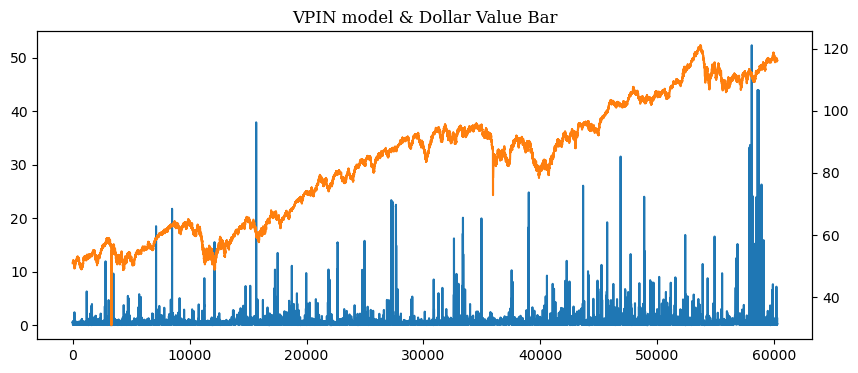

In [40]:
plt.figure(figsize=(10, 4))
vpin_series.plot()
bars['close'].plot(secondary_y = True)
plt.title('VPIN model & Dollar Value Bar', fontsize = 12, fontfamily = 'Serif')

Text(0.5, 1.0, 'VPIN model & Dollar Value Bar')

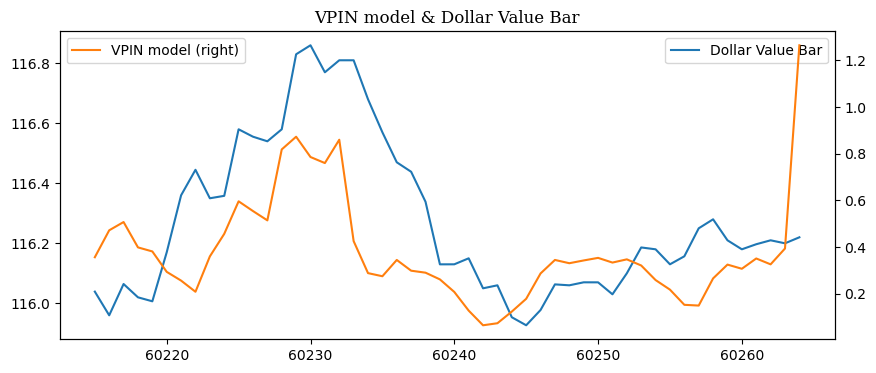

In [45]:
plt.figure(figsize=(10, 4))
bars['close'][-50:].plot(label = 'Dollar Value Bar')
plt.legend()
vpin_series[-50:].plot(label = 'VPIN model', secondary_y = True)
plt.legend()
plt.title('VPIN model & Dollar Value Bar', fontsize = 12, fontfamily = 'Serif')